#### Import packages

The following cell will import the Python packages we need for this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, fixed
from scipy.optimize import minimize, LinearConstraint, Bounds
from scipy.linalg import sqrtm
%matplotlib inline

# **How to diversify your stock portfolio?** 
#### ***an introduction to Markowitz's modern portfolio theory***

Each farmer knows that you should not put all your eggs in one basket. The same holds true when you invest money in stocks: you should diversify your portfolio. Whereas the diversification strategy for eggs is rather straightforward, just distribute the eggs uniformly over some baskets, the situation is less clear for stocks. Should we distribute our money uniformly over the available stocks? Or are smarter strategies available? This notebook discusses the modern portfolio theory, introduced by Harry Markowitz, that provides the optimal composition of your investment portfolio.


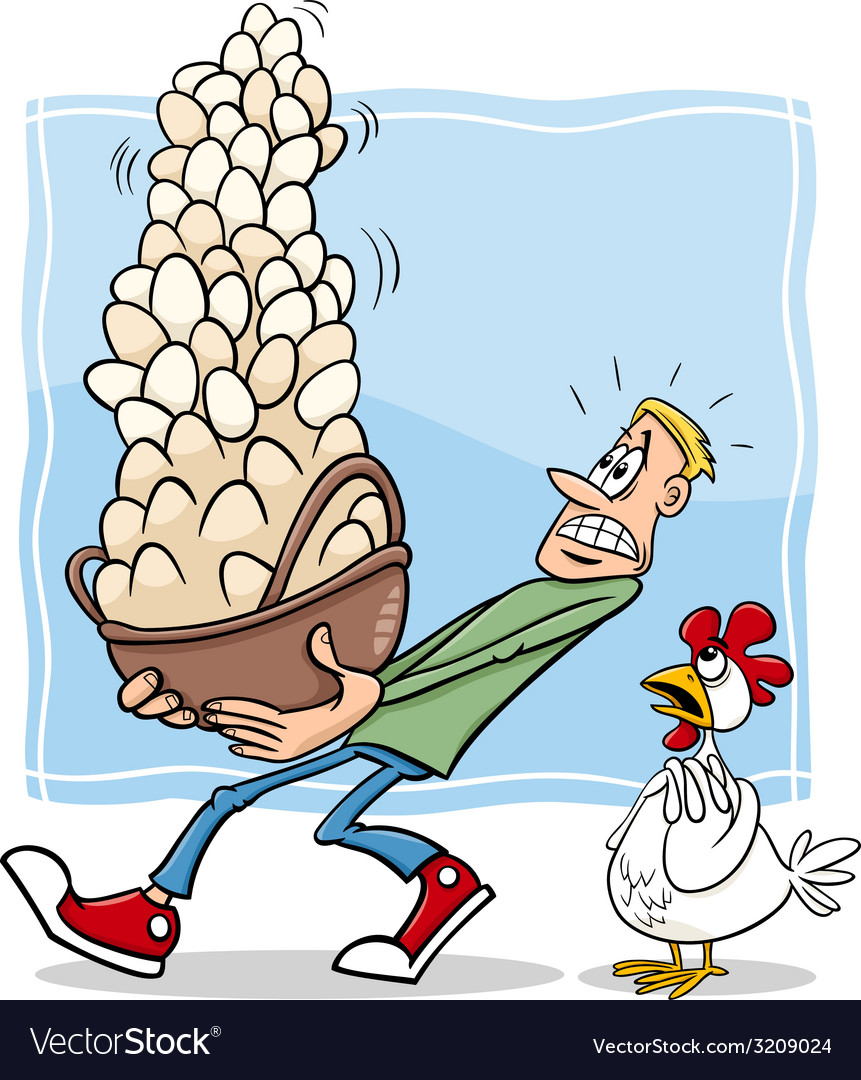

The "modern" porfolio theory traces back to an essay entitled *portfolio selection*, published in 1952, and Markowitz's 1959 book *portfolio selection: efficient diversification*. For these works Markowitz was awarded, in 1990, one third of the Nobel prize in economic sciences. (The other parts were rewarded to Merton Miller and William Sharpe; see [link](https://www.nobelprize.org/prizes/economic-sciences/1990/press-release/) for more information.)

## 1. Overview

If you set up an investment portfolio you are (typically) interested in the reward and the risk that is involved. The modern portfolio theory measures the reward of each stock  by the *expected return* on the stock and the risk by the *standard deviation* of its return. The *expected return* is the best estimate of the return and the standard deviation measures the degree of uncertainty. In case the return would follow a normal probability distribution, an expected return of 8% and a standard deviation of 10% would imply that the realized return will be between $8-2\times 10 = -12\%$ and $8 + 2\times 10 = 28\%$ with a probability of 95%. Precise definitions of the return of a portfolio, the expected return, and the standard deviations will be given later on. Obviously, we want to have a high expected return and low variance.


While knowledge of the expected return and variance is sufficient to compare stocks, we need more information to determine the risk of a portfolio of stocks. This is also intuitive: returns on different stocks are dependent, i.e. if one of the baskets with eggs falls, the other tends to fall as well. 
As an illustration the figure below considers the evolution of the S$\&$P 500 and the Dow Jones. You can clearly see that these indices tend to `move together'.  Such association can be measured by the concept of  *correlation*. In this notebook we will see that the risk of the portfolio return is completely determined by the variances of the stock returns (i.e. the risk of every asset) and all the pairwise correlations (to take the association into account).

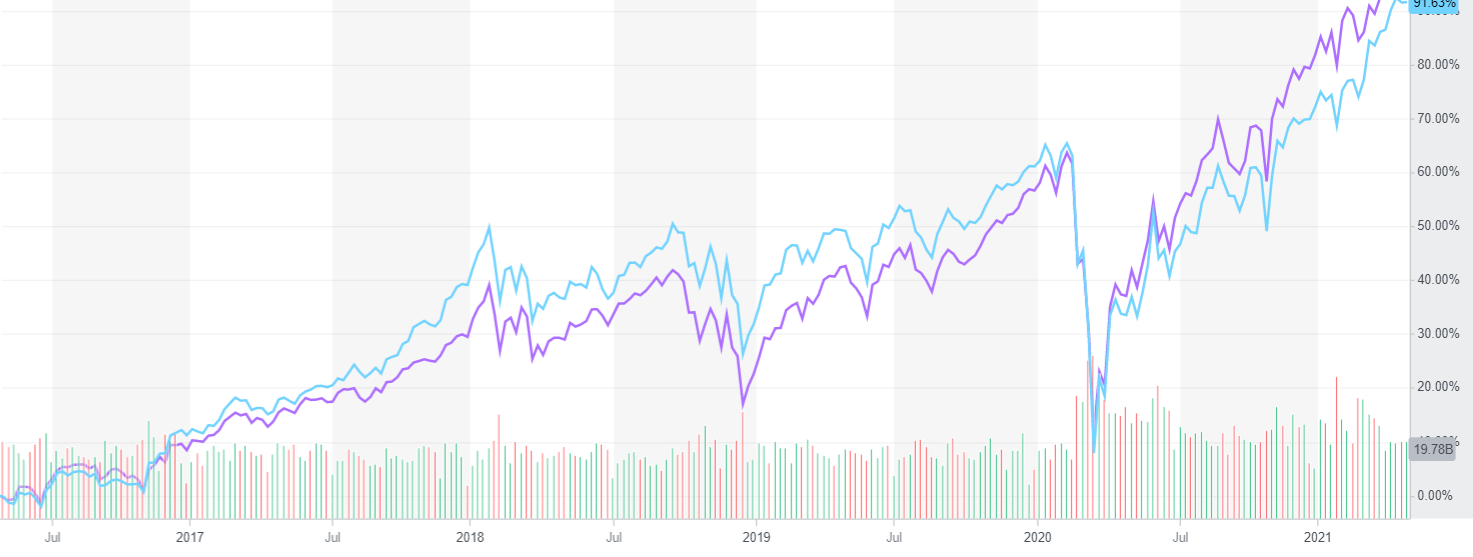

Suppose that we have two stocks in which we can invest our money. Both stocks have an expected return of 10%.  For stock A the standard deviation is equal to 20% and for stock B the standard deviation equals 25%. If we are only allowed to pick one stock the answer is clear: stock A has the same reward as stock B, but a lower risk. 

If we are, however, given the opportunity to build a portfolio that invests in both stocks, then we can wonder if we could beat stock A. Let us first consider a situation in which the correlation between the returns is equal to -50%.  This would mean that stock A tends to move up when stock B tends down and vice versa. Intuitively, investing in both stocks simultaneously we can hedge part of the risk. It will turn out that we can indeed substantially reduce the amount of risk: for an expected return of 10% we can reduce the standard deviation to 11.1% by investing 57% of our money in stock A and 43% in stock B. 

Of course, in real life most stocks exhibit a positive correlation. But even in such situations it helps to spread your money over the stocks:  in case of a correlation of +50% we can reduce the standard deviation to 18.9%. In this case we should invest 71% of our budget in stock A.

In [2]:
variance1 = 0.20 ** 2
variance2 = 0.25 ** 2
rho = 0.5
w_opt = 2 * (variance2 - rho * np.sqrt(variance1) * np.sqrt(variance2)) / (2 * (variance1 + variance2 -2 * rho * np.sqrt(variance1) * np.sqrt(variance2)))
def compute_variance_portfolio(variance1, variance2, correlation, weight):
  return (weight ** 2) * variance1 + ((1 - weight) ** 2) * variance2 +  2 * weight * (1 - weight) * correlation * np.sqrt(variance1) * np.sqrt(variance2)
stdev_portfolio = np.sqrt(compute_variance_portfolio(variance1, variance2, rho, w_opt))
print(f"For correlation {100 * rho:.2f}%:")
print(f"The standard deviation of the portfolio return, using the formula, is {100 * stdev_portfolio:.2f}%.")
print(f"The optimal value is w={w_opt:.2f}.")
rho = -.5
print(f"For correlation {100 * rho:.2f}%:")
w_opt = 2 * (variance2 - rho * np.sqrt(variance1) * np.sqrt(variance2)) / (2 * (variance1 + variance2 -2 * rho * np.sqrt(variance1) * np.sqrt(variance2)))
stdev_portfolio = np.sqrt(compute_variance_portfolio(variance1, variance2, rho, w_opt))
print(f"The standard deviation of the portfolio return, using the formula, is {100 * stdev_portfolio:.2f}%.")
print(f"The optimal value is w={w_opt:.2f}.")

For correlation 50.00%:
The standard deviation of the portfolio return, using the formula, is 18.90%.
The optimal value is w=0.71.
For correlation -50.00%:
The standard deviation of the portfolio return, using the formula, is 11.09%.
The optimal value is w=0.57.


In this notebook all concepts that are needed to understand Markowitz's modern portfolio theory will be discussed. In particular, the portfolio optimization problem will be extended to the situation that we might have more than two stocks and perhaps also have constraints on our portfolio (think, for example, of limiting the exposure to airliners).

In Section 1 we review the probabilistic concepts, Section 2 discusses the return of a portfolio and how you can compute its expectation and stand deviation, and in Section 3 we derive the optimal investment portfolios. Section 4 provides a short discussion and references for further reading are organized in Section 5. 

# 1. A simple probabilistic model to evaluate stock returns

This section introduces the notation and setup in case only one stock is available. The concepts return, expected return/mean, variance, and standard deviation will be introduced. 

Suppose that we have an investment horizon, for example one year, and that we consider a stock with (current) price $P_{current}$. Let us denote the price at the end of the investment horizon by $P_T$.   

Obviously, we currently do not know the value of $P_T$. To account for the intrinsic uncertainty, we model $P_T$ as a *random variable*. To this end we specify an *outcome space* $\Omega$ that describes the states of the world that could occur, the *probabilities* of these states, and for each of the outcomes in this space we need to specify what value $P_T$ takes. 

In the end, we will only need to know, for each stock, the expected value and variance of its return and, for each pair of stocks, the correlation between the returns. These quantities can be estimated from historical data. 

To carefully explain all concepts we, however, first consider an artificial example. We consider a very simple (unrealistic) setting in which there are only three different future states of the world: $\Omega = \{ \text{down}, \text{base}, \text{up}\}$ where 'down' reflects a downturn of the economy, 'base' a steady-state scenario, and 'up' a booming economy. 
The following probabilities are associated to the states: $\mathbb{P}(\text{base}) = 0.5$, $\mathbb{P}(\text{down})=0.2$, and $\mathbb{P}(\text{up})=0.3$. And we set $P_{current} = 100$, $P_T(\text{base}) = 100$, $P_T(\text{up}) = 120$, and $\mathbb{P}_T(\text{down}) = 90$. As mentioned above, in the end we do not need to specify $\Omega$ and $\mathbb{P}$ to apply Markowitz's portfolio theory. 

The following cell organizes the working example into Python code.


In [2]:
price1_current = 100
df = pd.DataFrame(index=["down", "base", "up"])
# values down state:
df.loc["down", "probability"] = .2
df.loc["down", "price1"] = 90
# values base state:
df.loc["base", "probability"] = .5
df.loc["base", "price1"] = 100
# values up state:
df.loc["up", "probability"] = .3
df.loc["up", "price1"] = 120
display(df)

,probability,price1
down,0.2,90.0
base,0.5,100.0
up,0.3,120.0


Next, we consider the return on the stock. The (simple) *return* is defined as $R = (P_T - P_{\text{current}}) /
P_{\text{current}}$. Of course, the return is also a random variable. The next cell evaluates the possible outcomes and the associated probabilities. 

In [3]:
df["return1"] = (df["price1"] - price1_current) / price1_current
display(df)

,probability,price1,return1
down,0.2,90.0,-0.1
base,0.5,100.0,0.0
up,0.3,120.0,0.2


Now we can calculate the *expected return*, also known as the mean return, which is defined as the probability-weighted outcome of the return.

In [5]:
def compute_expected_return(df, name_column, name_column_probabilities):
  return np.sum(df[name_column] * df[name_column_probabilities])
  
expected_return1 = compute_expected_return(df, "return1", "probability")
print(f"The expected return is {100 * expected_return1:.2f}%.")

The expected return is 4.00%.


An investor obviously prefers to have a high expected return. Consider, however, a second stock with current price $P_{2,\text{current}} = 210$, 
 $P_T(\text{base}) = 100$, $P_T(\text{up}) = 870$, and $\mathbb{P}_T(\text{down}) = 5$. The following cell computes the expected return of this stock.

In [6]:
price2_current = 210
# values down state:
df.loc["down", "price2"] = 5
# values base state:
df.loc["base", "price2"] = 100
# values up state:
df.loc["up", "price2"] = 870
df["return2"] = (df["price2"] - price2_current) / price2_current
display(df)
expected_return2 = compute_expected_return(df, "return2", "probability")
print(f"The expected return of stock 2 is {100 * expected_return2:.2f}%.")

,probability,price1,return1,price2,return2
down,0.2,90.0,-0.1,5.0,-0.976190
base,0.5,100.0,0.0,100.0,-0.523810
up,0.3,120.0,0.2,870.0,3.142857


The expected return of stock 2 is 48.57%.


Stock 2 has an expected return that is extremely high. However, at the same time it seems very risky as you loose more than 50% of your money in the 'down' and 'base' states and the probability of ending up in one of these states is 70%. This demonstrates that we cannot assess stocks on basis of their expected return only. 

In Markowitz's modern portfolio theory the variance (or the standard deviation) of the return is used to measure the risk. The *variance* bold text of a random variable $X$ is given by $\operatorname{var}(X)=  \mathbb{E}(X -\mathbb{E}[X]  )^2 = \sum_{\omega\in\Omega} \mathbb{P}(\{\omega\}) (X(\omega) - \mathbb{E}[X])^2$, i.e. the probability-weighted average squared-deviation of outcomes from the mean (expected value). In case there is no uncertainty at all in the outcomes of $X$, i.e. for all possible states of the world the outcome $X(\omega)$ is the same, the variance is equal to 0. The *standard deviation* of $X$ is defined by $\sqrt{\operatorname{var}(X)}$. 

Let us calculate the variance and standard deviation for both stocks.

In [7]:
def compute_variance_and_stdev(df, name_column, name_column_probabilities):
  expected_return = compute_expected_return(df, name_column, name_column_probabilities)
  aux = df[name_column] - expected_return
  variance = np.sum(aux * aux * df["probability"]) 
  return variance, np.sqrt(variance)
variance1, stddev1 = compute_variance_and_stdev(df, "return1", "probability")
variance2, stddev2 = compute_variance_and_stdev(df, "return2", "probability")
print(f"The standard devation of the return on stock 1 equals {100 * stddev1:.1f}%.")
print(f"The standard devation of the return on stock 2 equals {100 * stddev2:.1f}%.")

The standard devation of the return on stock 1 equals 11.1%.
The standard devation of the return on stock 2 equals 174.8%.


Observe that the earlier observed extreme risk for stock 2 is reflected in a large value of the standard deviation.

In case two stocks have the same expected return then you prefer the one with the lowest standard deviation. And, similarly, if two stocks have the same variance/standard deviation then you prefer the one with the highest expected return.

The above setup thus allows us to compare different stocks on basis of a risk versus reward trade-off, where reward is measured via the expected return and the risk is measured via the variance. However, if multiple stocks are available then we could also decide to spread our money over the stocks, i.e. to build a portfolio. We want to assess portfolios on basis of their expected return and variance as well. The following section will discuss how we can compute these measures on basis of the information provided for the individual stocks.




# 2. Evaluating the return on a stock portfolio & diversification

## 2.1 Return on a portfolio and calculus rules for its expected return and variance

In the previous section we have considered the case in which we should invest either in stock 1 or in stock 2. In this section we consider the situation in which we have an investment budget available and can invest
this money in both stocks.

Suppose we have an investment budget of 1,000 euro and invest a fraction $w$ in stock 1  and $1-w$ in stock 2. For example, $w=0.5$ means that we invest 50$\%$ of our budget in stock 1. 

If we are interested in the return on the porfolio then we can use the formula $R_p = w R_1 + (1-w) R_2$ where $R_1$ and $R_2$ denote the returns on stock 1 and stock 2 respectively. This formula can be proved mathematically. We will not do so in this notebook, but will verify this formula for our working example, in the following cell, by comparing its outcomes to a directly calculated portfolio return. 


In [8]:
# Direct method to compute return portfolio
investment_budget = 1000
w = 0.4
number_stocks1 = (w * investment_budget) / price1_current
number_stocks2 = ((1 - w) * investment_budget) / price2_current
price_portfolio_current = number_stocks1 * price1_current + number_stocks2 * price2_current
df["price_portfolio"] = number_stocks1 * df["price1"] + number_stocks2 * df["price2"]
df["return_portfolio_direct"] = (df["price_portfolio"] - price_portfolio_current) / price_portfolio_current
# Using the formula
df["return_portfolio"] = w * df["return1"] + (1 - w) * df["return2"]  
# Display results
display(df)

,probability,price1,return1,price2,return2,price_portfolio,return_portfolio_direct,return_portfolio
down,0.2,90.0,-0.1,5.0,-0.976190,374.285714,-0.625714,-0.625714
base,0.5,100.0,0.0,100.0,-0.523810,685.714286,-0.314286,-0.314286
up,0.3,120.0,0.2,870.0,3.142857,2965.714286,1.965714,1.965714


The formula $R_p = w R_1 + (1-w) R_2$ and probability theory imply that we can compute the expected return on the portfolio via $\mathbb{Ë}[R_p]=w \mu_1 + (1-w) \mu_2$ where $\mu_1$ and $\mu_2$ denote the expected return on stock 1 and stock 2 respectively. Of course, we can also compute the expected return directly.  Let us verify, for our working example, that the two approaches indeed yield the same answer. 

In [9]:
# direct approach:
expected_return_portfolio_direct = compute_expected_return(df, "return_portfolio", "probability")
print(f"The expected return of the portfolio, using direct computations, is {100 * expected_return_portfolio_direct:.2f}%.")
# using the formula:
expected_return_portfolio = w * expected_return1 + (1 - w) * expected_return2
print(f"The expected return of the portfolio, using the formula, is {100 * expected_return_portfolio:.2f}%.")

The expected return of the portfolio, using direct computations, is 30.74%.
The expected return of the portfolio, using the formula, is 30.74%.


The variance of the return of the portfolio can also be expressed in terms of the variances of the returns on the stocks. However, these quantities are not sufficient to determine the variance of the portfolio return. This is also intuitive: the variance measures the risk of the portfolio and you would expect that this risk somehow also depends on how the two stock returns move together. Do they tend to move in the same direction or not? This association is measured by the concept of correlation which we will briefly review. After that we will be able to express the portfolio variance in terms of the variances of the returns on the stocks and the correlation between the stock returns.

Recall from probability theory that the **covariance** between two random variables $X$ and $Y$ is defined as $\operatorname{cov}(X,Y)=\mathbb{E}(X- \mathbb{E}[X])(Y-\mathbb{E}[Y])$. In turn, the **correlation** between $X$ and $Y$ is defined as $\operatorname{corr}(X,Y)= \operatorname{cov}(X,Y) / (\operatorname{std}(X)\operatorname{std}(Y))$. It can be shown that the correlation takes values between -1 and 1. A positive correlation means that return $R_1$ tends to be above its mean when return $R_2$ is also above its mean. In other words, a positive correlation means that the prices of the two stocks tend to simultaneously go 'up' and 'down'. And a negative correlation means that return $R_1$ tends to be above its mean when return $R_2$ is below its mean.

In the following cell we compute the covariance and correlation for our working example.

In [10]:
def compute_covariance_and_correlation(df, name_column1, name_column2, name_column_probabilities):
  expected_return1 = compute_expected_return(df, name_column1, name_column_probabilities)
  expected_return2 = compute_expected_return(df, name_column2, name_column_probabilities)
  aux1 = df[name_column1] - expected_return1
  aux2 = df[name_column2] - expected_return2
  covariance = np.sum(aux1 * aux2 * df[name_column_probabilities]) 
  _, stdev1 = compute_variance_and_stdev(df, name_column1, name_column_probabilities)
  _, stdev2 = compute_variance_and_stdev(df, name_column2, name_column_probabilities)
  correlation = covariance / (stdev1 * stdev2)
  return covariance, correlation
covariance, correlation = compute_covariance_and_correlation(df, "return1", "return2", "probability")
print(f"The covariance between the two returns is {covariance:.2f} and the correlation is {correlation:.2f}.")

The covariance between the two returns is 0.19 and the correlation is 0.97.


Now we can express the variance of the portfolio return in terms of the variances of the stock returns and their correlation: $\operatorname{var}(R_p)= w^2\operatorname{var}(R_1) + (1-w)^2 \operatorname{var}(R_2) +2 w (1-w) \operatorname{corr}(R_1, R_2)\operatorname{std}(R_1)\operatorname{std}(R_1)$. 
The correlation $\operatorname{corr}(R_1, R_2)$ is often abbreviated to $\rho$ or $\rho_{1,2}$.

We will not prove the validity of this formula in this notebook, but we will verify it for our working example. We will compute the portfolio variance directly as well as via the formula.

In [11]:
# direct computation:
variance_portfolio_direct, _ = compute_variance_and_stdev(df, "return_portfolio", "probability")
print(f"The variance of the portfolio return, using direct computations, is {variance_portfolio_direct:.2f}.")
# using the formula:
def compute_variance_portfolio(variance1, variance2, correlation, weight):
  return (weight ** 2) * variance1 + ((1 - weight) ** 2) * variance2 +  2 * weight * (1 - weight) * correlation * np.sqrt(variance1) * np.sqrt(variance2)
variance_portfolio = compute_variance_portfolio(variance1, variance2, correlation, w)
print(f"The variance of the portfolio return, using the formula, is {variance_portfolio:.2f}.")

The variance of the portfolio return, using direct computations, is 1.19.
The variance of the portfolio return, using the formula, is 1.19.


Recall that Markowitz's modern portfolio theory assesses the quality of a portfolio on basis of its expected return and its variance (or standard deviation). This section obtained "calculus rules" for the expected return and variance of the portfolio. For our working example, in which we have specified the outcome space $\Omega$ and the probability measure $\mathbb{P}$, this was actually not needed: we could compute the expected return and variance directly.  The point is that the calculus rules allow us to fully ignore the specification of $\Omega$ and $\mathbb{P}$. Indeed, if we are told what the expected returns, the variances, and the correlation are of the stocks involved, then we can calculate the portfolio expected return and variance. This is much easier than specifying the data generating process for the returns.






## 2.2 Diversification

In the previous subsection we have seen how we can express the return of a portfolio, its expected return and its variance in terms of metrics on the returns on the stocks.

More specifically, we have seen that the return of the portfolio follows from the returns $R_1$ and $R_2$ via $R_p = w R_1 + (1-w) R_2$ where $w$ denotes the fraction of the investment budget that is invested in stock 1. The expected return on the portfolio follows from the formula $\mathbb{E}[R_p]=w \mu_1 + (1-w) \mu_2$. And the variance of the portfolio is given by $\operatorname{var}(R_p)= w^2\operatorname{var}(R_1) + (1-w)^2 \operatorname{var}(R_2) +2 w (1-w) \operatorname{cov}(R_1, R_2)$.

As Markowitz's modern portfolio measures the reward of a portfolio via its expected value and its risk via the variance, we see that we actually do not need to know $\Omega$ and $\mathbb{P}$. All we care about are $\mu_1,\mu_2, \operatorname{stdev}(R_1), 
\operatorname{stdev}(R_2)$, and $\rho$. 

Suppose now that we have two stocks for which $\mu_1=\mu_2=\mu$ and $\operatorname{stdev}(R_1)= 
\operatorname{stdev}(R_2)=\sigma$, i.e. the two stocks have exactly the same reward and risk. Could it make sense in this case to mix the two assets or would this be equivalent to just putting all money into one of the stocks?

Our formulas imply that $\mathbb{E}[R_p] = \mu$, so the expected return is the same for all values of the weight $w$. The variance, however, depends on the weight $w$: $\operatorname{var}(R_p)= \sigma^2 ( w^2 + (1-w)^2 ) + 2w (1-2) \rho \sigma^2$.

Let us first consider the situation in which the correlation between $R_1$ and $R_2$ is negative. We wonder wether it would be possible to obtain a portfolio that has less variance than the individual stocks. As the portfolio and the stocks always have the same expected return in our example, this would show that diversifying your investments indeed helps to reduce the risk.


In [12]:
variance1 = 3
variance2 = variance1
rho = -.5
w = .5
variance_portfolio = compute_variance_portfolio(variance1, variance2, rho, w)
print(f"The variance of the portfolio return, for w={w:.2f} and rho={rho:.2f}, equals {variance_portfolio:.2f}.")

The variance of the portfolio return, for w=0.50 and rho=-0.50, equals 0.75.


Observe that we have significantly reduced the risk by mixing the stocks. As they have the same expected returns and exhibit a negative correlation, this is actually rather intuitive. It is perhaps less intuitive that diversifying your portfolio also helps in case of a positive correlation. 

In [13]:
rho = .5
variance_portfolio = compute_variance_portfolio(variance1, variance2, rho, w)
print(f"The variance of the portfolio return, for w={w:.2f} and rho={rho:.2f}, equals {variance_portfolio:.2f}.")

The variance of the portfolio return, for w=0.50 and rho=0.50, equals 2.25.


The above examples clearly demonstrate the benefits of diversification. Here we just chose to use $w=0.5$. The following section will address the question what the best possible value of $w$ is.

# 3. How to determine the weights of the porfolio?

# 3.1 Starting simple: optimal weights in case of two stocks with the same mean

Just as in Section 2.2 we assume that $\mathbb{E}[R_1]=\mathbb{E}[R_2]=\mu$ which also implies, irrespective of the chosen weight $w$, $\mathbb{E}[R_p]=\mu$, i.e. the expected return is the same for all values of the weight $w$.

The variance of $R_p$ is given by  $\operatorname{var}(R_p)=  w^2 \operatorname{var}(R_1) + (1-w)^2 \operatorname{var}(R_2) + 2w (1-w) \rho \operatorname{std}(R_1)\operatorname{std}(R_2)$. The following widget plots the standard deviation of $R_p$ as a function of $w$ and you can analyze the effects of the parameters $\rho$ and $\operatorname{var}(R_2)$. Throughout,  $\operatorname{var}(R_1)=1$ is used. You can visually determine the value of the weight $w$ for which the portfolio variance is minimal.

In [14]:
def plot_graph_stdev(variance1, variance2, correlation):
  w_vector = np.linspace(-1.5, 1.5, 200)
  stdev_portfolio = np.sqrt(compute_variance_portfolio(variance1, variance2, correlation, w_vector))
  plt.plot(w_vector, stdev_portfolio)
  plt.xlabel("w")
  plt.ylabel("standard deviation")
  plt.title(f"Standard deviation portfolio return as function of w for rho={correlation:.2f}, var(R_1)=1, and var(R_2)={variance2:.2f}.")
config_correlation = [-.9, -.5, 0, .5, .9]
config_variance2 = [.8, 1, 1.5]
widgets.interact(plot_graph_stdev, variance1=fixed(1), variance2=config_variance2,
                  correlation=config_correlation)


interactive(children=(Dropdown(description='variance2', options=(0.8, 1, 1.5), value=0.8), Dropdown(descriptio…

<function __main__.plot_graph_stdev>

Note that the graph also allows for values of $w$ that are outside of the interval $[0,1]$. You probably implicitly assumed that we must have $w\in [0,1]$. So what does it mean if you use a weight outside of the interval $[0,1]$?  If, for example, $w=-0.5$ then we are short-selling stock 1 and using the proceedings to invest this money, on top of the investment budget, in stock 2.

From the graph the value of $w$ that minimizes the variance of the portfolio can be detected. However, as we are dealing with a function that is quadratic in $w$, the optimal value of $w$ is actually immediate.


In [15]:
variance1 = 1
variance2 = 1.5
rho = 0.5
w_opt = 2 * (variance2 - rho * np.sqrt(variance1) * np.sqrt(variance2)) / (2 * (variance1 + variance2 -2 * rho * np.sqrt(variance1) * np.sqrt(variance2)))
print(f"The optimal value is w={w_opt:.2f}.")

The optimal value is w=0.70.


Up to now we have assumed that $\mu_1=\mu_2$ which is, of course, unrealistic. In the next section we will discuss the general case and will also allow for more than two stocks.

# 3.2 The general case:  optimal weights

In this section we consider $k$ risky assets with returns $R_1,\dots,R_k$. We need to decide on the weight-vector that specifies how much money we invest in each of the stocks. We denote the weight-vector by  $w=(w_1,\dots,w_k)$, where $w_j$ specifies the weight for stock $j$. The weights should, of course, sum up to 1, i.e. our choice for $w$ should satisfy $\sum_{j=1}^k w_j =1$. In this section we will derive the optimal specification for $w$ in case we judge portfolios on basis of their expected return and variance.


In Section 2.1 we provided formulas for the expected value of $R_p$ and its variance in case $k=2$. We now need the formulas for the general case. Not surprisingly, the expected return on the portfolio can be written as $R_p= \sum_{j=1}^k w_j \mu_j$, where $\mu_j$ denotes the expected return on the $j$th stock. The formula for the variance of the portfolio return is a bit more cumbersome: $\operatorname{var}(R_p)= \sum_{j=1}^k w_j^2\operatorname{var}(R_j)
+2 \sum_{j=1}^k \sum_{\ell=j+1}^k w_j w_\ell  \rho_{j,\ell} \operatorname{std}(R_j)\operatorname{std}(R_\ell)$. We do not verify the validity of this formula in this notebook; please consult a textbook on probability theory for further details. The key observation, in line with our discussion for the case $k=2$, is that the variance of the portfolio depends on all the individual variances as well as all pairwise correlations.

Suppose that we have an investor who would like to receive $\mu_p$ as expected return. The questions now is if we can set the weight-vector $w$ such that the expected return indeed equals $\mu_p$ and such that the variance of the portfolio return is minimal.

In case no short-selling constraints are imposed one can actually solve the associated optimization problem analytically, i.e. obtain a closed-form formula that expresses the optimal value of $w$ in terms of all the parameters. This, however, requires some knowledge on linear algebra and constrained optimization theory. In this notebook we avoid this, by relying on numerical optimization routines. This will also allow you to add your own, additional constraints.

First, we need to specify the characteristics of the stocks. In this notebook we consider $k=4$ with expected returns, variances, and correlations as specified in the following cell.

In [16]:
mu = np.array([[0.05, 0.14, 0.02, 0.09]])
stdev = np.array([0.09, 0.30, 0.03, 0.11])
variance = stdev ** 2
Corr = np.array([[1.0, 0.5, 0.4, 0.7], [0.5, 1.0, .3, .2], [0.4, .3, 1.0, .1], [0.7, .2, .1, 1.0]])
Sigma = np.matmul(np.diag(stdev), np.matmul(Corr, np.diag(stdev)))
print(f"The expected returns of the stocks are given by {mu}.")
print(f"The standard deviations of the returns on the stocks are given by {stdev}.")
print(f"The correlations between the returns on the stocks are given by {Corr}.")

The expected returns of the stocks are given by [[0.05 0.14 0.02 0.09]].
The standard deviations of the returns on the stocks are given by [0.09 0.3  0.03 0.11].
The correlations between the returns on the stocks are given by [[1.  0.5 0.4 0.7]
 [0.5 1.  0.3 0.2]
 [0.4 0.3 1.  0.1]
 [0.7 0.2 0.1 1. ]].


So by investing in one stock only we can obtain expected returns in the range 2%-14%. And an expected return of 14% would be paired with a standard deviation of 30%. The returns on stock 3 and stock 4 are mildly correlated as their correlation is only 10%. 

Stock 3 has the lowest standard deviation: 3%. You could wonder if it is possible to build a portfolio that has a lower standard deviation. We answer this question by choosing $w$ such that $\operatorname{var}(R_p)$ is minimal.

In [17]:
def variance_portfolio(Sigma, w):
  """This function computes var(R_p) for portfolio weight-vector w."""
  return np.matmul(w, np.matmul(Sigma, w))
def solve_optimization(mu, Sigma, mu_p=None):
  """This function determine the weight-vector w such that var(R_p) is minimal
  under the contraint that E[R_p] = mu_p. In case mu_p is not specified, then
  the constraint is ignored. Of course, the weight-vector is such that the
  weights sum to 1."""
  if mu_p is None:
    linear_constraint = LinearConstraint(np.ones(4), 1, 1)
  else:
    linear_constraint = LinearConstraint([[1, 1, 1, 1], [mu[0][0], mu[0][1], mu[0][2], mu[0][3]]], [1, mu_p], [1, mu_p])
  w0 = np.zeros(4)
  w0[1] = 1
  res = minimize(lambda w: variance_portfolio(Sigma, w), w0, method='trust-constr', constraints=linear_constraint)
  w_optimal = res.x
  mu_p = np.float(np.matmul(mu, w_optimal))
  variance_p = np.matmul(w_optimal, np.matmul(Sigma, w_optimal))
  return w_optimal, mu_p, variance_p
w_optimal, mu_p, variance_p = solve_optimization(mu, Sigma)
print(f"The minimal standard deviation is {100 * np.sqrt(variance_p):.2f}%.")
print(f"The weights of this portfolio are given by {w_optimal}.")
print(f"And the expected return of this portfolio is {100 * mu_p:.2f}%.")

The minimal standard deviation is 2.82%.
The weights of this portfolio are given by [-0.10379126 -0.01365726  1.01231181  0.10513672].
And the expected return of this portfolio is 2.26%.


So we see that by mixing the stocks we can obtain a lower standard deviation!

Stock 2 has the highest expected return, 14%, with a standard deviation equal to 30%. Let us investigate what the minimal standard deviation is, imposing that the expected return should be equal to 14%, when we can invest in a portfolio consistint of the four stocks.

In [19]:
w_optimal, mu_p, variance_p = solve_optimization(mu, Sigma, 0.14)
print(f"The minimal standard deviation is {100 * np.sqrt(variance_p):.2f}%.")
print(f"The weights of this portfolio are given by {w_optimal}.")
print(f"And the expected return of this portfolio is {100 * mu_p:.2f}%.")

The minimal standard deviation is 15.46%.
The weights of this portfolio are given by [-1.26196233  0.3228267   0.23742611  1.70170952].
And the expected return of this portfolio is 14.00%.


Observe that the standard deviation, for the same expected return of 14%, has been decreased by a factor 2. Also note that this requires short-selling of stocks 1.

Of course, we can repeat the above exercise for multiple values of the desired expected return on the portfolio. The cell below plots the relationship between this desired expected return and the best possible standard deviation of $R_p$. This graph is known as the "efficient frontier".

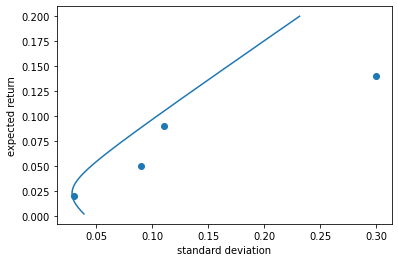

In [20]:
mu_p_vector = np.linspace(0.002, .2, 200)
stdev_p_vector = []
for mu_p in mu_p_vector:
  _, _, variance_p = solve_optimization(mu, Sigma, mu_p)
  stdev_p_vector.append(np.sqrt(variance_p))
plt.plot(stdev_p_vector, mu_p_vector)
plt.ylabel("expected return")
plt.xlabel("standard deviation")
plt.scatter(stdev, mu)

The points in the graph correspond to the (standard deviation, expected return) pairs for the four stocks. The graph thus implies that it is not a good idea to invest all your money in one of these stocks: at the same level of risk (standard deviation) you can obtain a better reward (higher expected return).

You can use the graph in two ways. If you want to have a certain expected return, you can see what the associated risk is. And, vice versa, if you have a bound on your risk tolerance you can read off what level of expected return you can obtain.

Please note that the above graph assumes that we allow for short-selling (i.e. negative values of $w_j$). If you want to avoid such positions, i.e. want to impose $w_j\geq 0$ for $j=1,\dots,k$, then we can adapt our optimization problem as follows.

In [21]:
def solve_optimization_without_shortselling(mu, Sigma, mu_p=None):
  """This function determine the weight-vector w such that var(R_p) is minimal
  under the contraint that E[R_p] = mu_p. In case mu_p is not specified, then
  the constraint is ignored. Of course, the weight-vector is such that the
  weights sum to 1."""
  if mu_p is None:
    linear_constraint = LinearConstraint(np.ones(4), 1, 1)
  else:
    linear_constraint = LinearConstraint([[1, 1, 1, 1], [mu[0][0], mu[0][1], mu[0][2], mu[0][3]]], [1, mu_p], [1, mu_p])
  bounds = Bounds([0, 0, 0, 0], [np.infty, np.infty, np.infty, np.infty])
  w0 = np.zeros(4)
  w0[1] = 1
  res = minimize(lambda w: variance_portfolio(Sigma, w), w0, method="trust-constr", constraints=linear_constraint, bounds=bounds)
  w_optimal = res.x
  mu_p = np.float(np.matmul(mu, w_optimal))
  variance_p = np.matmul(w_optimal, np.matmul(Sigma, w_optimal))
  return w_optimal, mu_p, variance_p
required_return = 0.12
w_optimal, mu_p, variance_p = solve_optimization(mu, Sigma, required_return)
print(f"Impose an expected return of {100 * required_return:.2f}%.")
print(f"If we allow for short-selling, then the minimal standard deviation is {100 * np.sqrt(variance_p):.2f}%.")
print(f"And the weights of this portfolio are given by {w_optimal}.")
w_optimal, mu_p, variance_p = solve_optimization_without_shortselling(mu, Sigma, required_return)
print(f"If we do not allow for short-selling, then the minimal standard deviation is {100 * np.sqrt(variance_p):.2f}%.")
print(f"And the optimal weights are given by {w_optimal}.")

Impose an expected return of 12.00%.
If we allow for short-selling, then the minimal standard deviation is 12.92%.
And the weights of this portfolio are given by [-1.06464769  0.26550067  0.36944202  1.42970501].
If we do not allow for short-selling, then the minimal standard deviation is 19.38%.
And the optimal weights are given by [5.46217629e-04 6.00716191e-01 1.99440360e-04 3.98538151e-01].


By comparing the outcomes of the two optimization we can thus assess what the "costs" of the additional constraints are. In the above example we see that imposing the constraints on short-selling increases the standard deviation by about 5%-points for a required expected return of 12%.

## 4. Conclusion and discussion

This notebook provided an introduction to Markowitz's modern portfolio theory. Central to this theory is the assumption that an investor makes a risk-reward assessment on basis of the expected return and the standard deviation of the portfolio return. This leads to a quadratic optimization problem that can be solved analytically. We, however, chose to use a numerical routine for the optimization in order to avoid lengthy mathematical derivations. Moreover, with our numerical routine we were also able to easily investigate the impact of a constraint on short-selling.

The input parameters for the optimization problem are the expected returns on the stocks involved, their variances, and the pairwise correlations. In the notebook we just specified these parameters ourselves. In practice one, of course, needs to estimate these parameters (e.g. on basis of historical data).

Using the variance as measure for the risk is often critized as variation in the right tail of the portfolio return distribution also contributes to the variance. Markowitz used the variance to obtain a quadratic optimization problem, which at the time (with the available (human) computing power) was essential to obtain an answer. Nowadays, many alternative risk measures do exist and can be handled numerically.

For the numerical optimization we used a general routine from Python's ScipPy package. However, as the Markowitz optimization problem is quadratic of nature it is actually better to use optimization routines that are specific to quadratic optimization problems.

This notebook analyzed the effects of constraints reflecting "no short-selling". The code can easily be extended to allow for additional constraints. For example, to impose that at most 20% of the budget is invested in airliners.

Finally, we note that we considered a static decision problem, i.e. we considered a "buy and hold" strategy. In practice, one typically wants to allow for rebalancing of the portfolio weights. Of course, extensions of Markowitz's theory that accommodate such requirements are available. 


## 5. Literature

* Luenberger, D.G. (2009) Investment science. Oxford University Press, New York.
* Markowitz, H.M. (1952). Portfolio selection, *Journal of Finance* 7, pp. 77-91.
* Markowitz, H.M. (1959). Portfolio selection: efficient diversification of investments. John Wiley & Sons Inc., New York.  